In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [83]:
def detect_missing_values(df):
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    return missing_data.sort_values(ascending=False)

def detect_outliers(df, columns):
    outliers = {}
    for column in columns:
            # Use IQR method
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outlier_rows = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
            outliers[column] = outlier_rows[[column]]
    
    return outliers

def detect_duplicates(df):
    duplicate_rows = df[df.duplicated()]
    return duplicate_rows

Dropped redundant rebound columns and renamed others for clarity.
Dropped 'divID' column as it contains no information.
Dropped 'seeded' column as it contains only zero values.
Dropped 'lgID', 'franchID', 'confID', 'name', and 'arena' as they are irrelevant for predictive modeling.

Missing Values
Series([], dtype: int64)

Duplicates
Empty DataFrame
Columns: [year, tmID, rank, playoff, o_fgm, o_fga, o_ftm, o_fta, o_3pm, o_3pa, o_oreb, o_dreb, o_reb, o_asts, o_pf, o_stl, o_to, o_blk, o_pts, d_fgm, d_fga, d_ftm, d_fta, d_3pm, d_3pa, d_oreb, d_dreb, d_reb, d_asts, d_pf, d_stl, d_to, d_blk, d_pts, won, lost, GP, homeW, homeL, awayW, awayL, confW, confL, min, attend, next_season_playoff, playoff_progression_score]
Index: []

[0 rows x 47 columns]


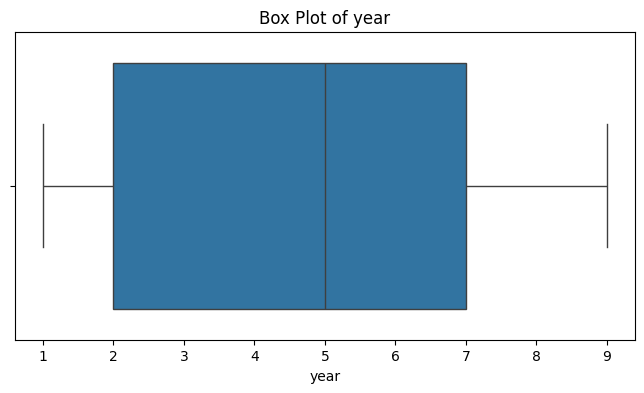

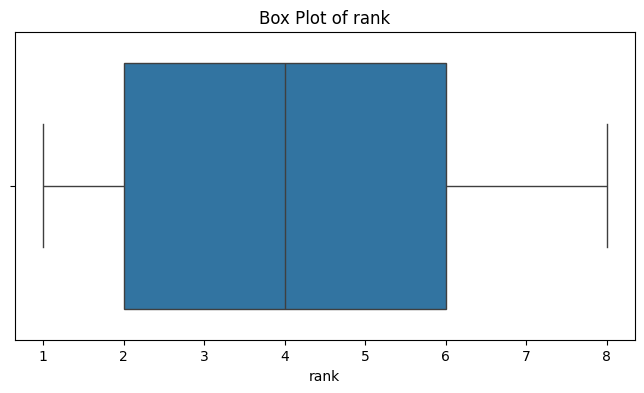

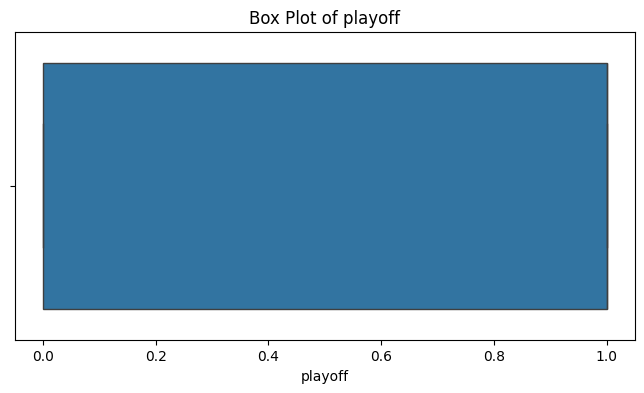

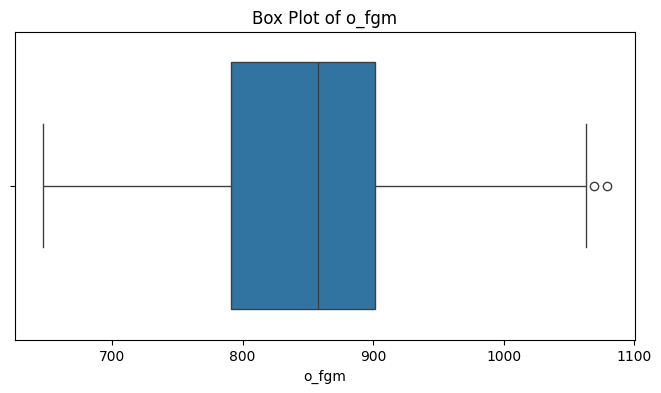

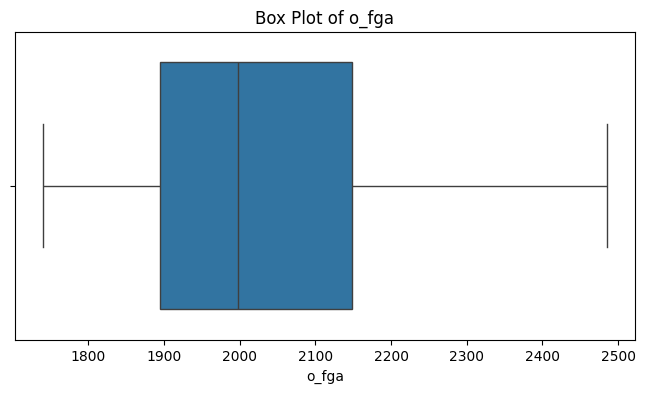

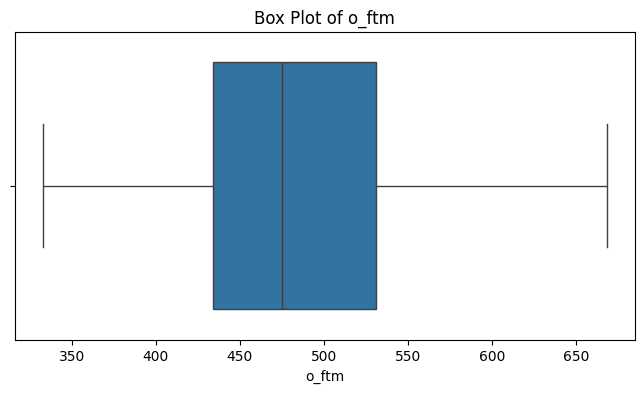

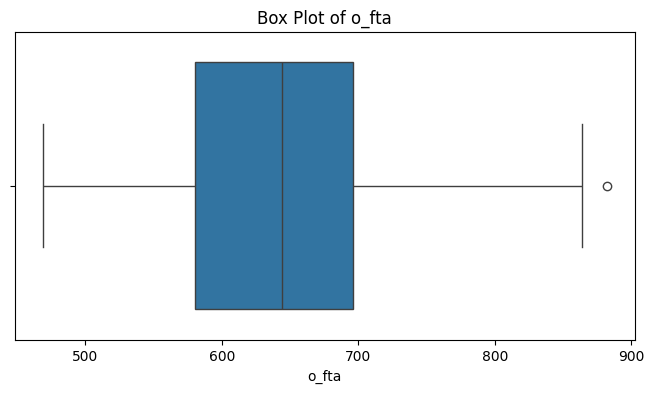

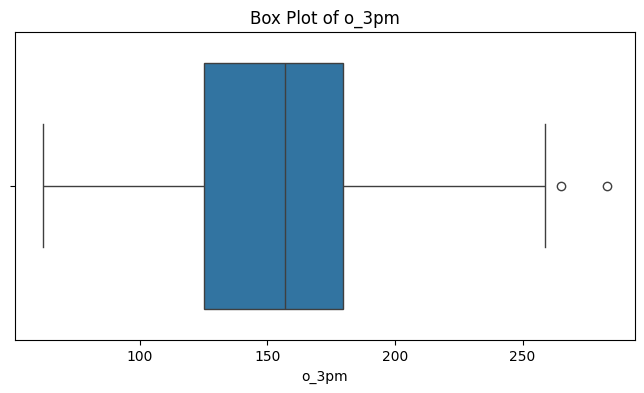

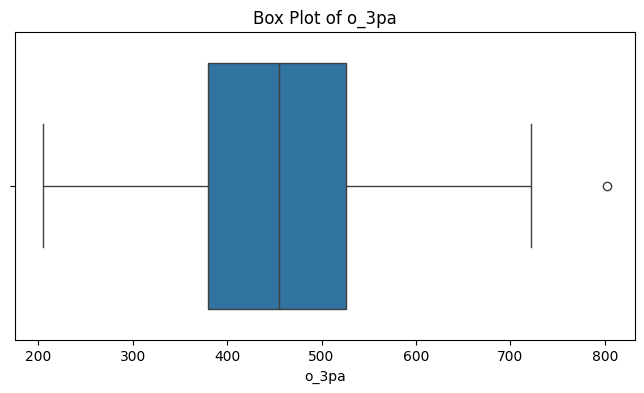

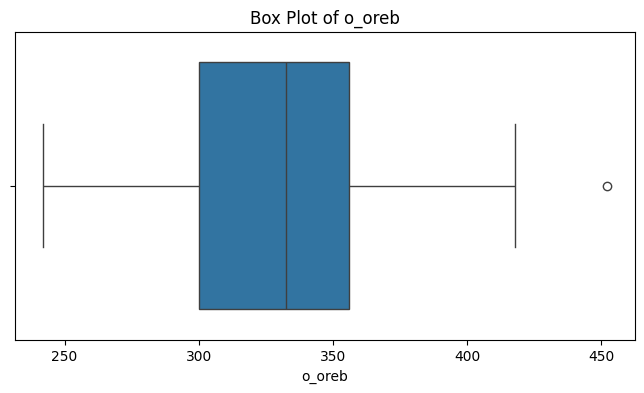

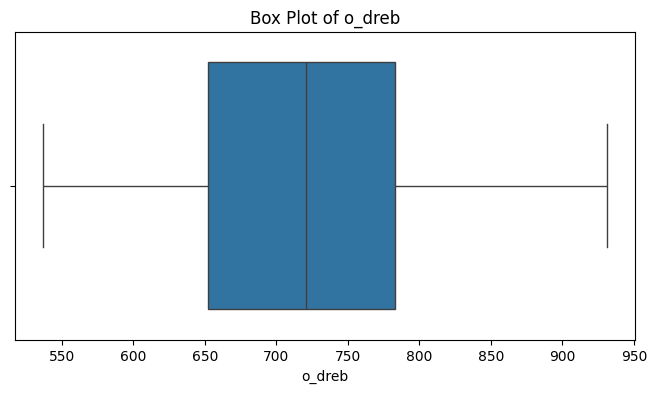

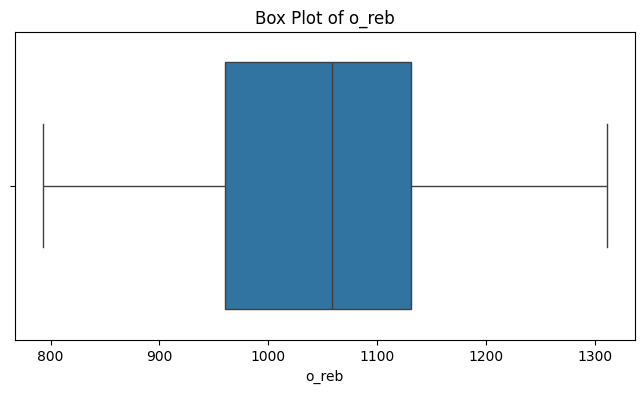

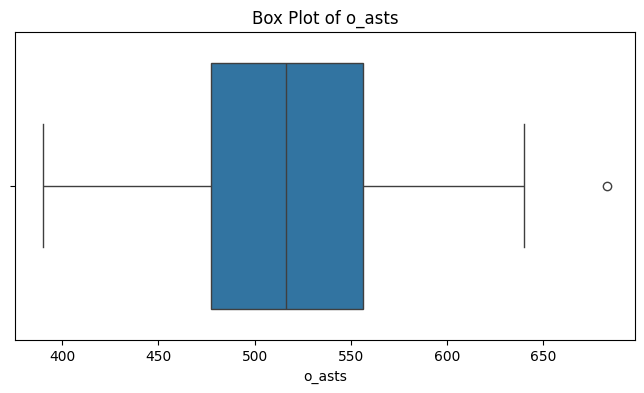

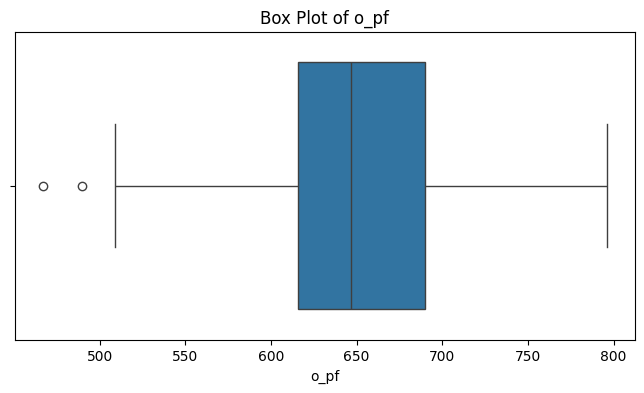

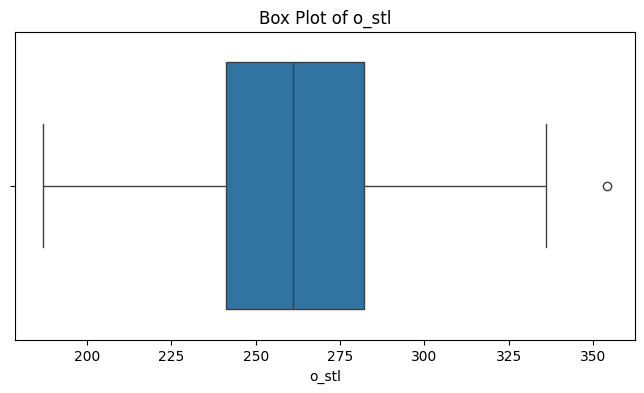

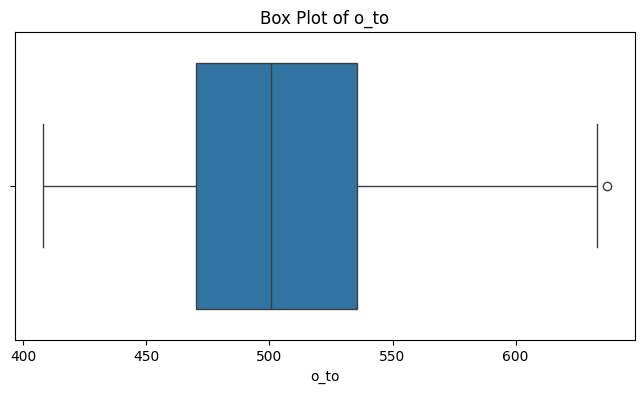

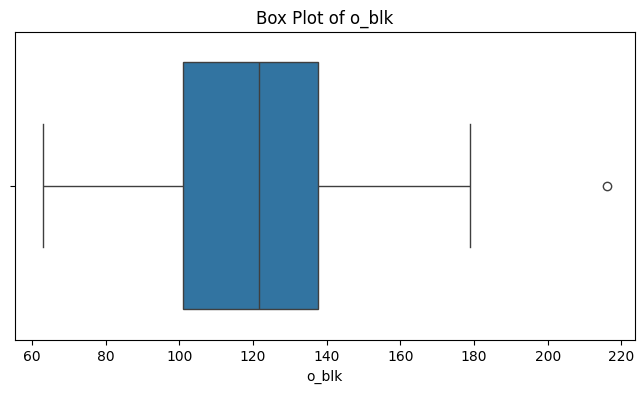

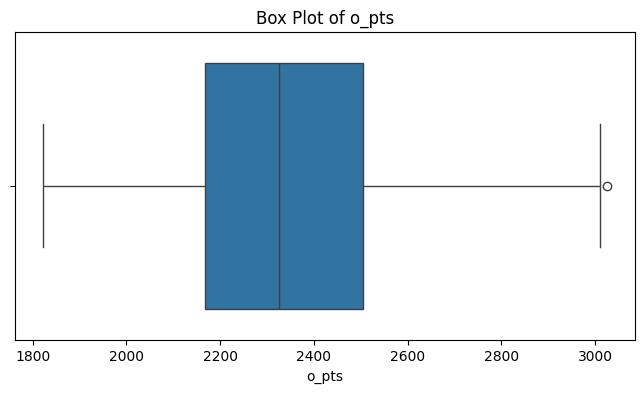

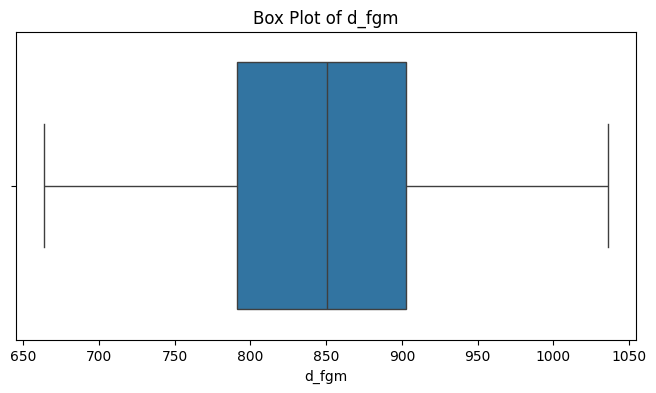

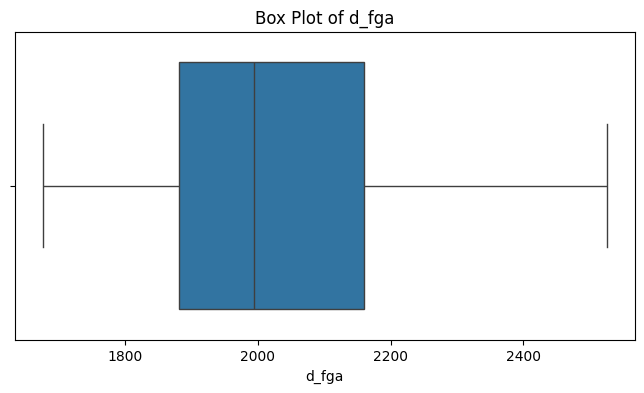

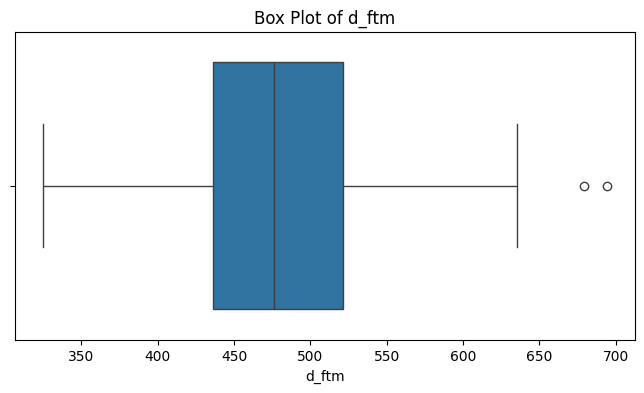

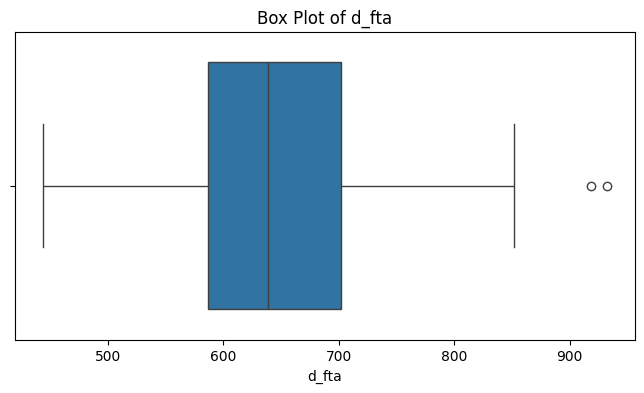

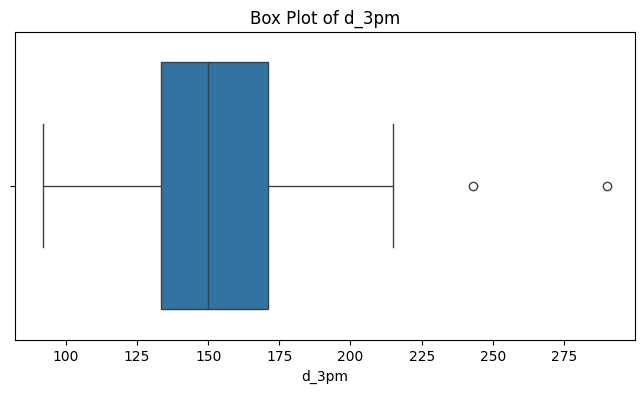

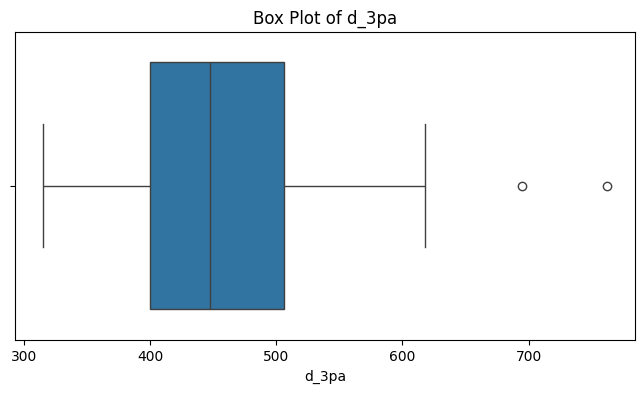

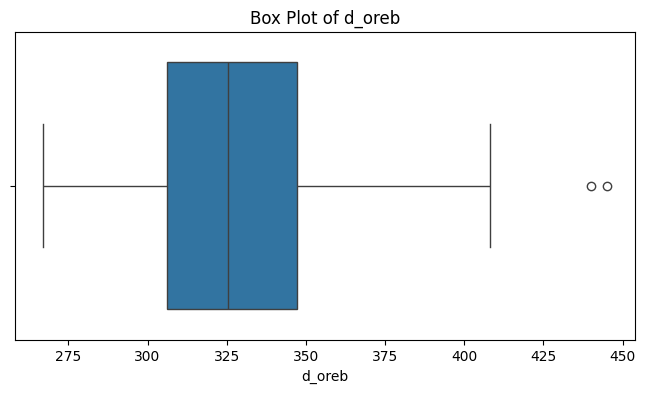

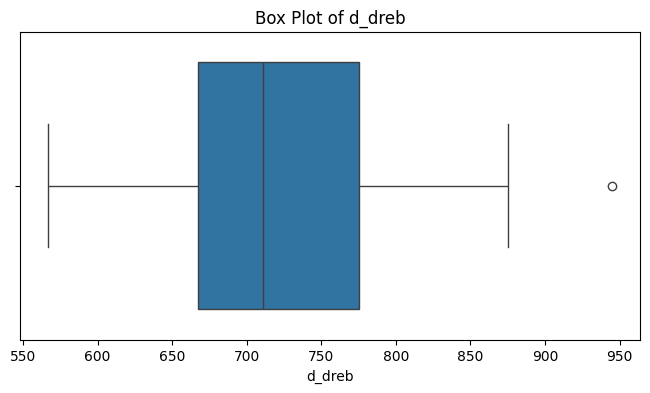

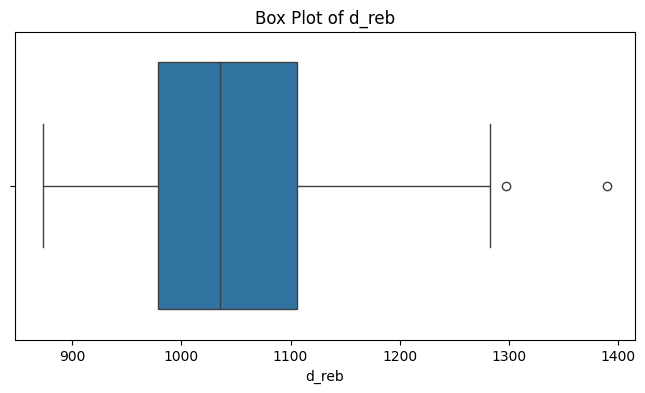

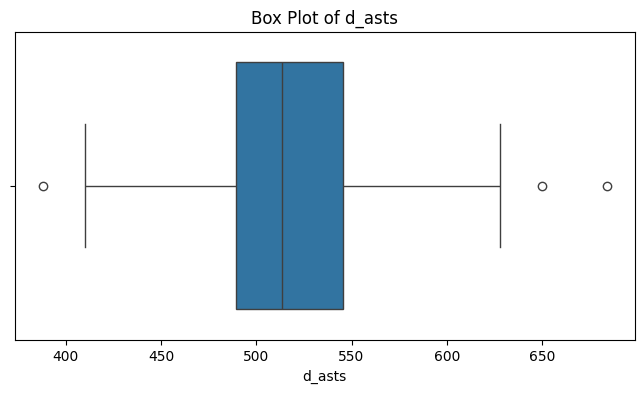

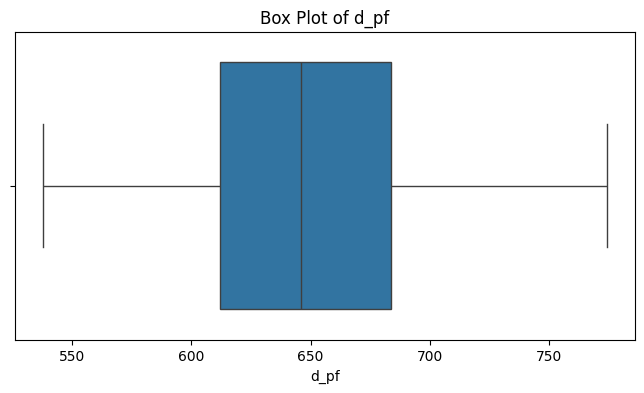

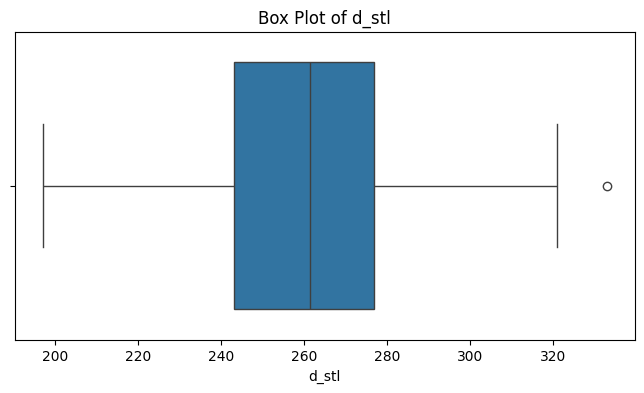

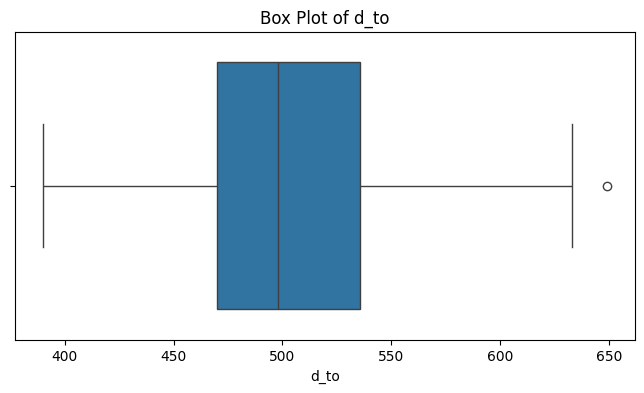

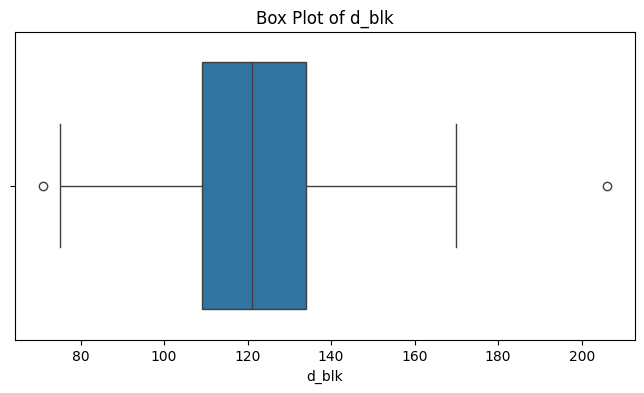

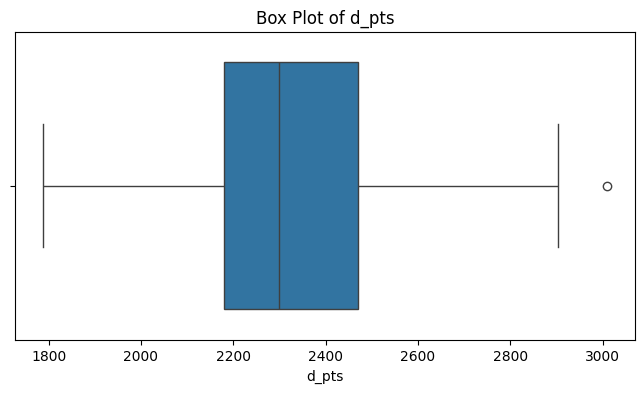

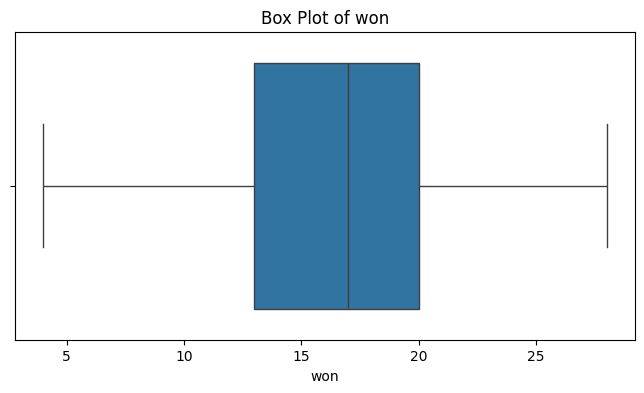

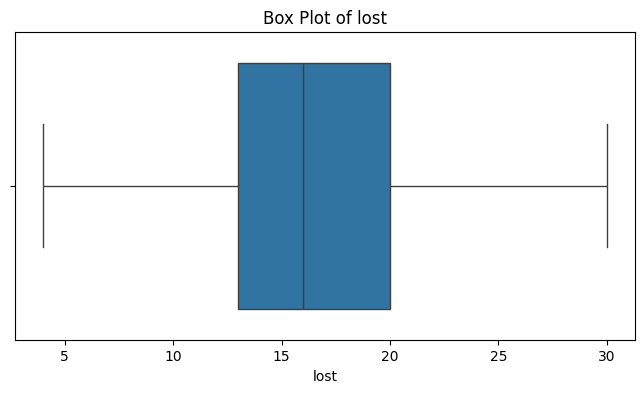

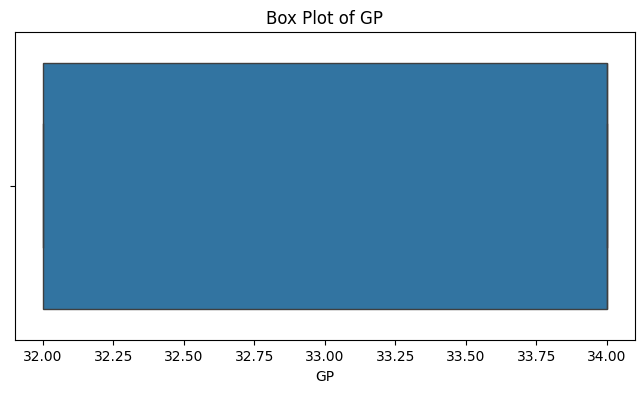

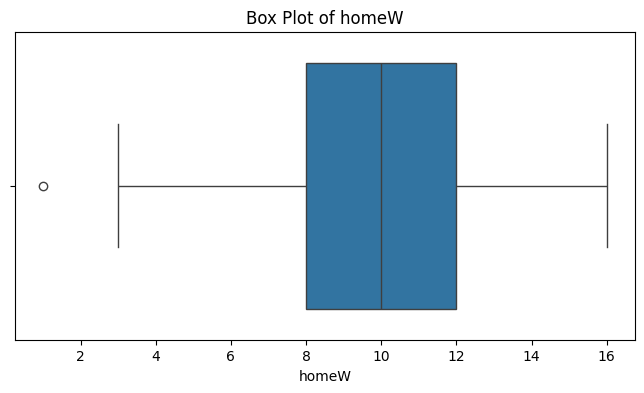

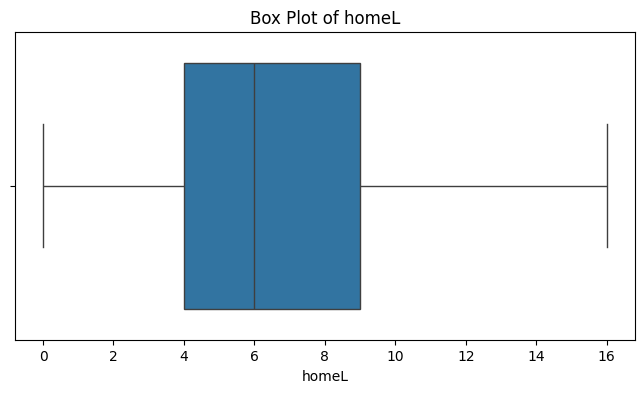

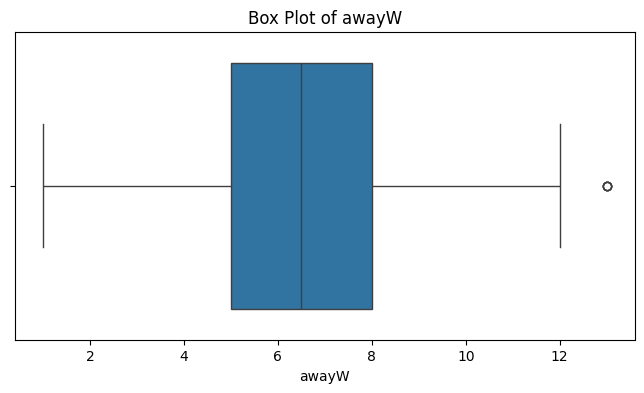

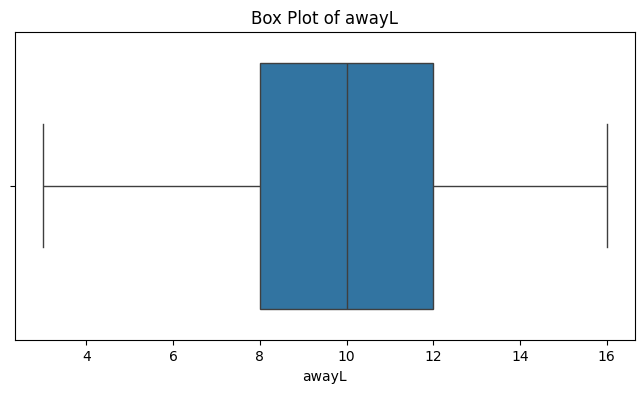

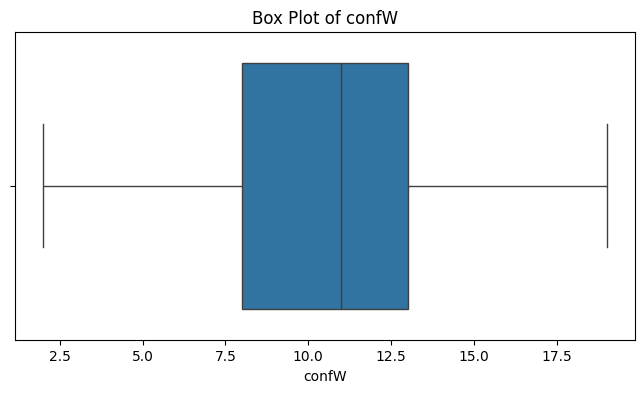

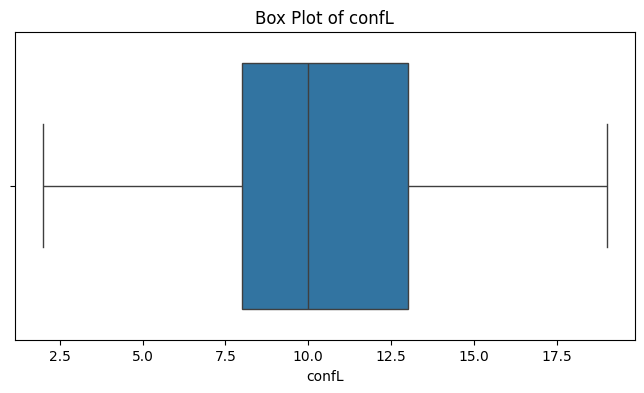

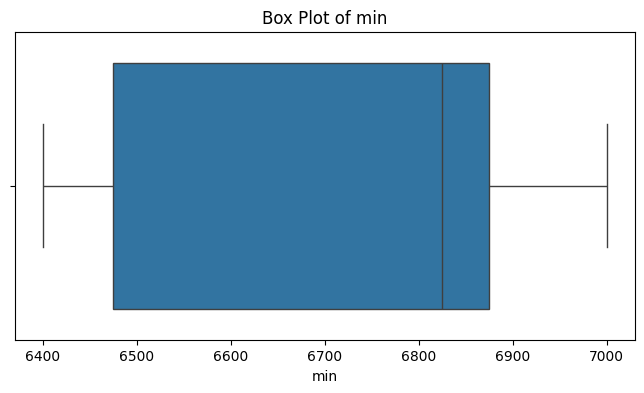

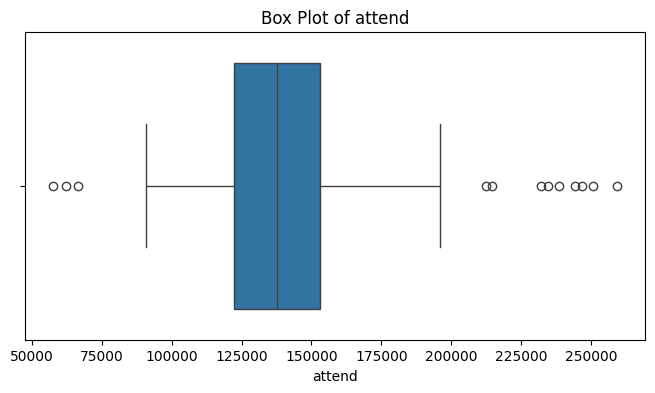

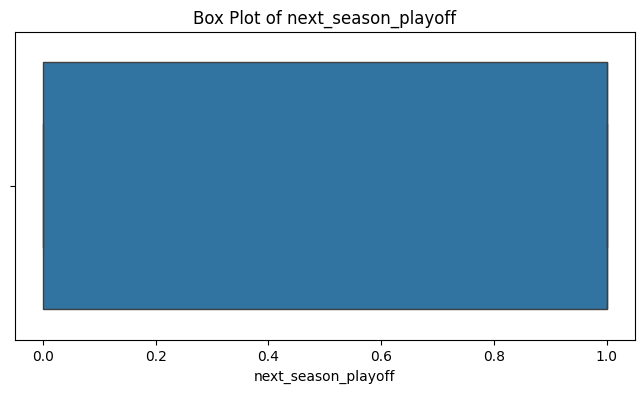

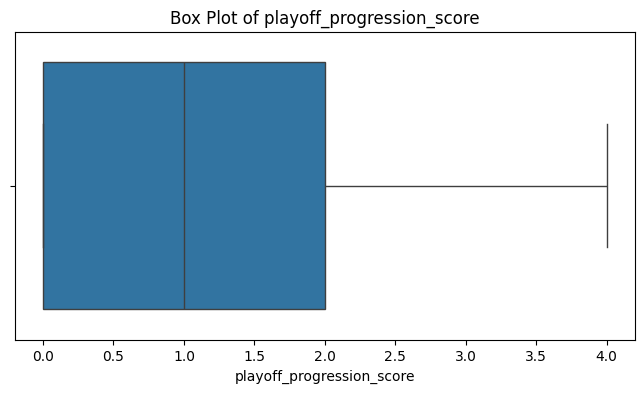

Outliers in year:
Empty DataFrame
Columns: [year]
Index: []

Outliers in rank:
Empty DataFrame
Columns: [rank]
Index: []

Outliers in playoff:
Empty DataFrame
Columns: [playoff]
Index: []

Outliers in o_fgm:
    o_fgm
95   1079
97   1069

Outliers in o_fga:
Empty DataFrame
Columns: [o_fga]
Index: []

Outliers in o_ftm:
Empty DataFrame
Columns: [o_ftm]
Index: []

Outliers in o_fta:
    o_fta
27    882

Outliers in o_3pm:
    o_3pm
95    265
96    283

Outliers in o_3pa:
    o_3pa
96    802

Outliers in o_oreb:
     o_oreb
109     452

Outliers in o_dreb:
Empty DataFrame
Columns: [o_dreb]
Index: []

Outliers in o_reb:
Empty DataFrame
Columns: [o_reb]
Index: []

Outliers in o_asts:
    o_asts
96     683

Outliers in o_pf:
    o_pf
36   467
37   490

Outliers in o_stl:
    o_stl
49    354

Outliers in o_to:
     o_to
140   637

Outliers in o_blk:
    o_blk
61    216

Outliers in o_pts:
    o_pts
96   3025

Outliers in d_fgm:
Empty DataFrame
Columns: [d_fgm]
Index: []

Outliers in d_fga:
Em

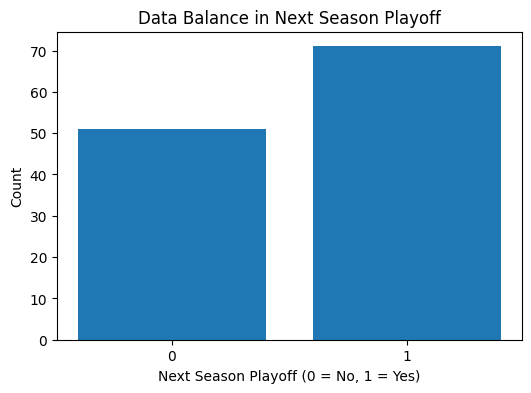

In [84]:
# Load the teams_post data
teams = pd.read_csv('./data/teams.csv')

# Convert 'playoff' column to binary (1 for 'Y', 0 for 'N')
teams['playoff'] = teams['playoff'].map({'Y': 1, 'N': 0})

# Sort the dataframe by team ID and year to ensure chronological order
teams = teams.sort_values(by=['tmID', 'year']).reset_index(drop=True)

# Create 'next_season_playoff' indicating playoff status in the next season
teams['next_season_playoff'] = teams.groupby('tmID')['playoff'].shift(-1)

# Drop rows where 'next_season_playoff' is NaN (last season for each team)
teams = teams.dropna(subset=['next_season_playoff'])

# Convert 'next_season_playoff' to integer type
teams['next_season_playoff'] = teams['next_season_playoff'].astype(int)

zero_cols = ["tmORB", "tmDRB", "tmTRB", "opptmORB", "opptmDRB", "opptmTRB"]

# Since "tmORB", "tmDRB", "tmTRB", "opptmORB", "opptmDRB", and "opptmTRB" contain only zero values,
# and are redundant with "o_oreb", "o_dreb", "o_reb" for team stats, and "d_oreb", "d_dreb", "d_reb" for opponent stats,
# we drop the redundant columns.

teams = teams.drop(columns=zero_cols)
print("Dropped redundant rebound columns and renamed others for clarity.")

# Drop the 'divID' column as it contains only empty strings and does not add useful information
teams = teams.drop(columns=['divID'])
print("Dropped 'divID' column as it contains no information.")

# Drop the 'seeded' column as it contains only zero values
teams = teams.drop(columns=['seeded'])
print("Dropped 'seeded' column as it contains only zero values.")

def calculate_playoff_score(row):
    if row['finals'] == 'W':
        return 4  # Won the championship
    elif row['finals'] == 'L':
        return 3  # Lost in the finals
    elif row['semis'] == 'L':
        return 2  # Lost in the semifinals
    elif row['firstRound'] == 'L':
        return 1  # Lost in the first round
    else:
        return 0  # Did not make the playoffs

# Apply the function to each row to create the playoff_progression_score
teams['playoff_progression_score'] = teams.apply(calculate_playoff_score, axis=1)

# Drop the original 'firstRound', 'semis', and 'finals' columns as they are now redundant
teams = teams.drop(columns=['firstRound', 'semis', 'finals'])

# Drop columns that don't add predictive value
# 'lgID': Contains only "WNBA" for every row, so it provides no additional information.
# 'franchID': Redundant identifier, as 'tmID' already identifies each team uniquely.
# 'confID': Lacks value without conference-specific qualification/matchup data.
# 'name': Purely descriptive and irrelevant to playoff predictions.
# 'arena': Also descriptive and does not impact playoff qualification.
teams = teams.drop(columns=['lgID', 'franchID', 'confID', 'name', 'arena'])
print("Dropped 'lgID', 'franchID', 'confID', 'name', and 'arena' as they are irrelevant for predictive modeling.")

# DETECTION OF MISSING VALUES
missing_values = detect_missing_values(teams)
print("\nMissing Values")
print(missing_values)

# DETECTION OF DUPLICATES
duplicate_rows = detect_duplicates(teams)
print("\nDuplicates")
print(duplicate_rows)

# DETECTION OF OUTLIERS
# Select numerical columns only
numeric_columns = teams.select_dtypes(include=['float64', 'int64']).columns

for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=teams[column])
    plt.title(f'Box Plot of {column}')
    plt.show()

outliers = detect_outliers(teams, numeric_columns)

for col, outlier_data in outliers.items():
    print(f"Outliers in {col}:\n{outlier_data}\n")

# DETECTION OF DATA IMBALANCE
next_playoff_counts = teams['next_season_playoff'].value_counts()

# Plot for 'next_season_playoff' column
plt.figure(figsize=(6, 4))
plt.bar(next_playoff_counts.index, next_playoff_counts.values)
plt.title('Data Balance in Next Season Playoff')
plt.xlabel('Next Season Playoff (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.xticks([0, 1])
plt.show()

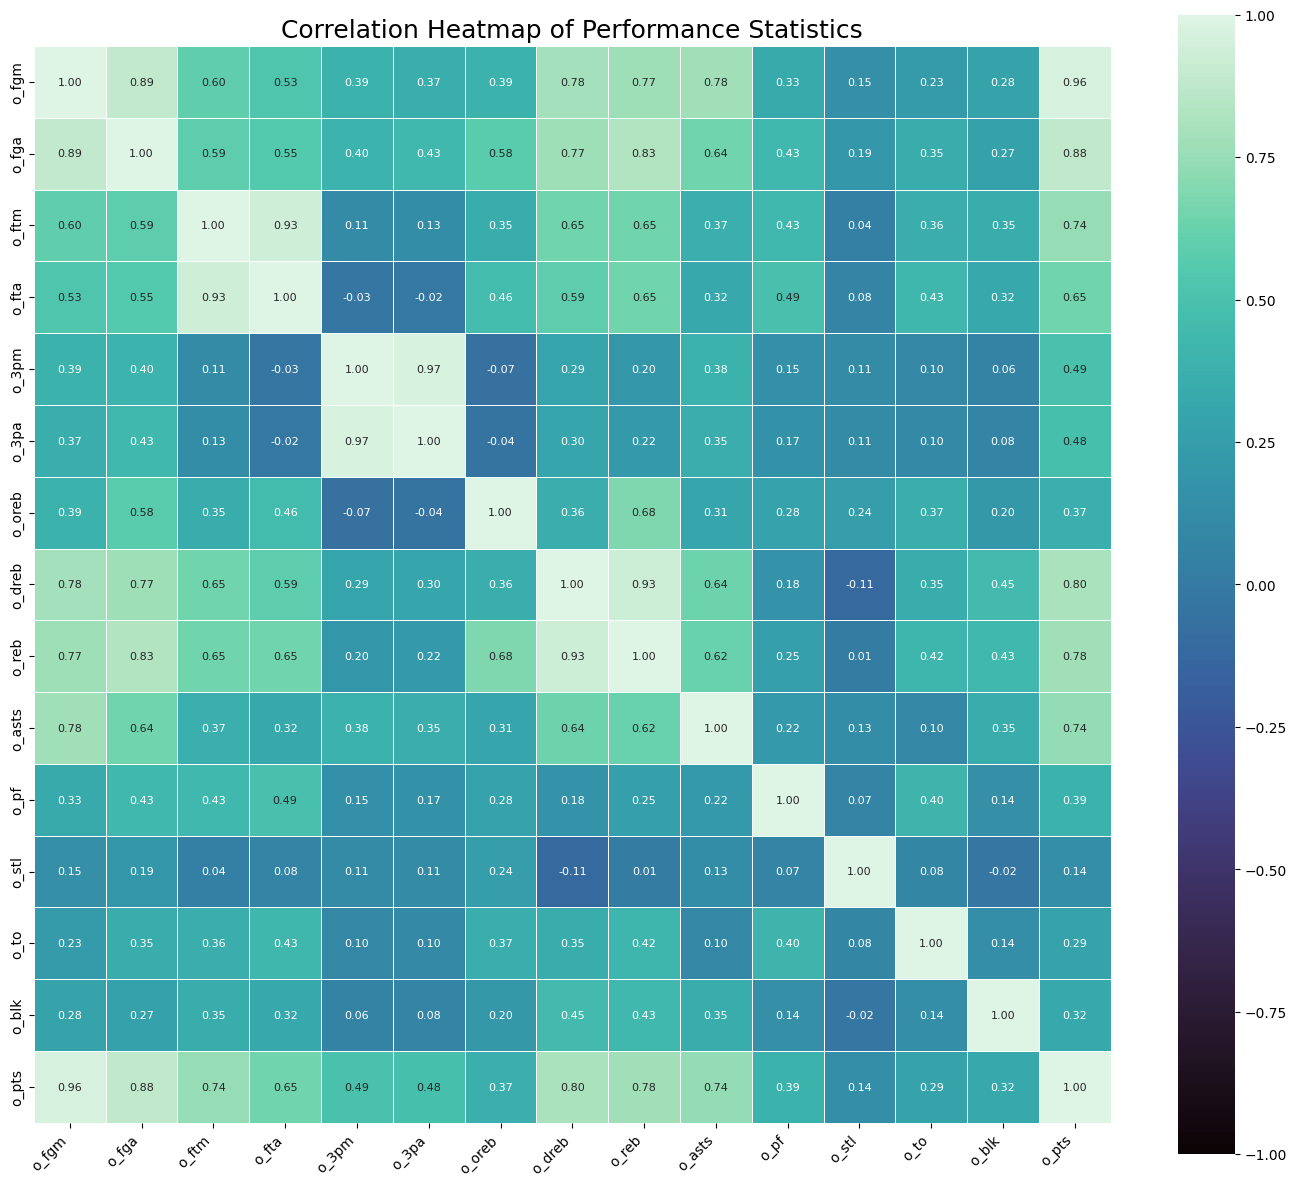

In [85]:
# Correlation between offensive statistics
# -------------------------

o_stats = teams.filter(regex='^(o_)')

corr_matrix = o_stats.corr()

plt.figure(figsize=(14, 12))

cmap = sns.color_palette("mako", as_cmap=True)

sns.heatmap(corr_matrix, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f", annot_kws={"size":8})

plt.title('Correlation Heatmap of Performance Statistics', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Display the heatmap
plt.show()

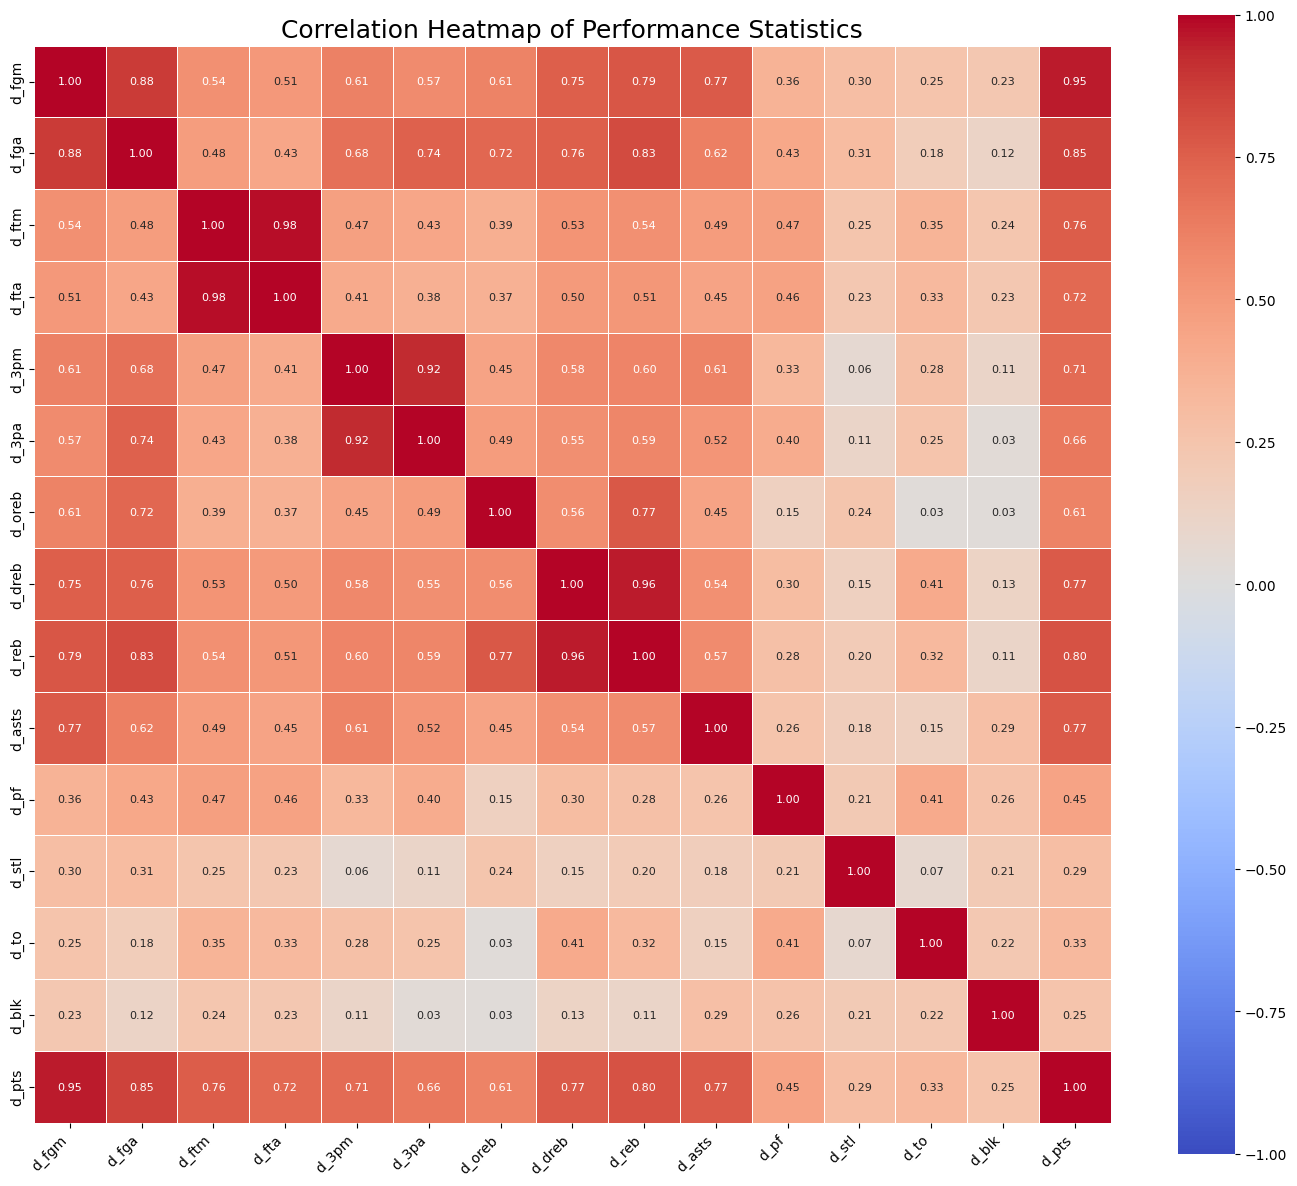

In [86]:
# Correlation between defensive statistics
# -------------------------

d_stats = teams.filter(regex='^(d_)')

corr_matrix = d_stats.corr()

plt.figure(figsize=(14, 12))

cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(corr_matrix, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f", annot_kws={"size":8})

plt.title('Correlation Heatmap of Performance Statistics', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Display the heatmap
plt.show()

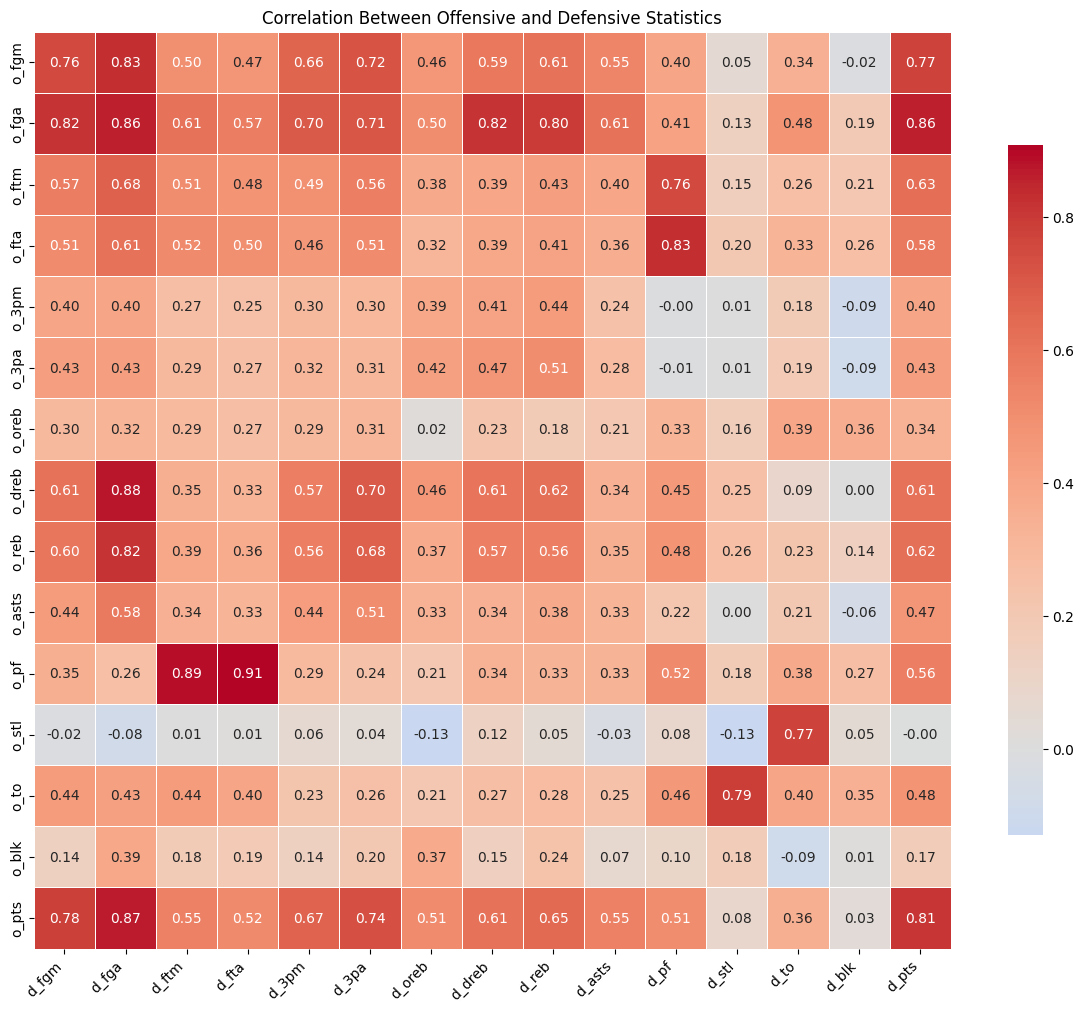

In [87]:
# Compute correlation between offensive and defensive stats
o_stats = teams.filter(regex='^(o_)')
d_stats = teams.filter(regex='^(d_)')

combined_stats = pd.concat([o_stats, d_stats], axis=1)

corr_matrix = combined_stats.corr()

o_d_corr_matrix = corr_matrix.loc[o_stats.columns, d_stats.columns]

plt.figure(figsize=(12, 10))
sns.heatmap(o_d_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=.5, square=True, cbar_kws={"shrink": .75})

plt.title("Correlation Between Offensive and Defensive Statistics")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()

In [88]:
# Separate features and target variable
X = teams.drop(columns=['year', 'tmID', 'next_season_playoff'])
y = teams['next_season_playoff']

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Verify the new class distribution after applying SMOTE
y_resampled.value_counts()

# Merge resampled data into a new DataFrame
balanced_data = pd.DataFrame(X_resampled, columns=X.columns)
balanced_data['next_season_playoff'] = y_resampled

teams = balanced_data

display(teams.head())

,rank,playoff,o_fgm,o_fga,o_ftm,o_fta,o_3pm,o_3pa,o_oreb,o_dreb,...,homeW,homeL,awayW,awayL,confW,confL,min,attend,playoff_progression_score,next_season_playoff
0,7,0,895,2258,542,725,202,598,340,737,...,1,16,3,14,2,18,6825,141379,0,1
1,8,0,812,1903,431,577,131,386,305,630,...,5,11,3,13,5,16,6475,90963,0,1
2,4,1,746,1780,410,528,153,428,309,639,...,11,5,7,9,15,6,6500,105525,3,1
3,2,1,770,1790,490,663,211,527,302,653,...,11,5,7,9,12,9,6450,106670,1,1
4,2,1,787,1881,456,590,187,517,342,629,...,13,4,5,12,12,12,6850,120061,1,0


In [89]:
# Engineering of advanced statistics based on research
# Effective Field Goal Percentage (eFG%) for the team and opponent
teams['eFG%'] = (teams['o_fgm'] + 0.5 * teams['o_3pm']) / teams['o_fga'] * 100
teams['opp_eFG%'] = (teams['d_fgm'] + 0.5 * teams['d_3pm']) / teams['d_fga'] * 100

# Net Effective Field Goal Percentage (Net eFG%)
teams['Net_eFG%'] = teams['eFG%'] - teams['opp_eFG%']

# Offensive and Defensive Ratings
teams['Off_Rating'] = (teams['o_pts'] / teams['GP']) * 100  # Points scored per 100 possessions
teams['Def_Rating'] = (teams['d_pts'] / teams['GP']) * 100  # Points allowed per 100 possessions

# Net Rating
teams['Net_Rating'] = teams['Off_Rating'] - teams['Def_Rating']

# Turnovers per Game (TO)
teams['TO_per_Game'] = teams['o_to'] / teams['GP']

# Rebounds per Game (REB)
teams['REB_per_Game'] = teams['o_reb'] / teams['GP']

# Pace calculation
teams['Possessions'] = 0.5 * ((teams['o_fga'] + 0.44 * teams['o_fta'] + teams['o_to'] - teams['o_reb']) + 
                              (teams['d_fga'] + 0.44 * teams['d_fta'] + teams['d_to'] - teams['d_reb']))
teams['Pace'] = teams['Possessions'] / teams['GP']

# Turnover Ratio (TOV%)
teams['TOV%'] = teams['o_to'] / teams['Possessions'] * 100

# True Shooting Percentage (TS%)
teams['TS%'] = teams['o_pts'] / (2 * (teams['o_fga'] + 0.44 * teams['o_fta'])) * 100

# Assist-to-Turnover Ratio (AST/TO)
teams['AST_TO_Ratio'] = teams['o_asts'] / teams['o_to']

# Free Throw Rate (FTR)
teams['FTR'] = teams['o_fta'] / teams['o_fga']

# Offensive and Defensive Rebounding Percentages
teams['OREB%'] = teams['o_oreb'] / (teams['o_oreb'] + teams['d_dreb']) * 100
teams['DREB%'] = teams['o_dreb'] / (teams['o_dreb'] + teams['d_oreb']) * 100

# Win Percentage
teams['Win%'] = teams['won'] / teams['GP'] * 100

# Home and Away Win Percentage
teams['Home_Win%'] = teams['homeW'] / (teams['homeW'] + teams['homeL']) * 100
teams['Away_Win%'] = teams['awayW'] / (teams['awayW'] + teams['awayL']) * 100

# Conference Win Percentage
teams['Conf_Win%'] = teams['confW'] / (teams['confW'] + teams['confL']) * 100

# Minutes per Game
teams['Min_per_Game'] = teams['min'] / teams['GP']

# Average Attendance per Game
teams['Avg_Attendance'] = teams['attend'] / teams['GP']

In [90]:
# Display a sample of the dataframe to verify changes
display(teams.head())

# Store cleaned csv
teams.to_csv('./cleaned_data/teams.csv', index=False)

,rank,playoff,o_fgm,o_fga,o_ftm,o_fta,o_3pm,o_3pa,o_oreb,o_dreb,...,AST_TO_Ratio,FTR,OREB%,DREB%,Win%,Home_Win%,Away_Win%,Conf_Win%,Min_per_Game,Avg_Attendance
0,7,0,895,2258,542,725,202,598,340,737,...,0.829680,0.321081,28.239203,64.762742,11.764706,5.882353,17.647059,10.000000,200.735294,4158.205882
1,8,0,812,1903,431,577,131,386,305,630,...,1.110887,0.303205,31.475748,65.899582,25.000000,31.250000,18.750000,23.809524,202.343750,2842.593750
2,4,1,746,1780,410,528,153,428,309,639,...,0.985232,0.296629,35.273973,65.005086,56.250000,68.750000,43.750000,71.428571,203.125000,3297.656250
3,2,1,770,1790,490,663,211,527,302,653,...,1.215686,0.370391,32.754881,68.881857,56.250000,68.750000,43.750000,57.142857,201.562500,3333.437500
4,2,1,787,1881,456,590,187,517,342,629,...,1.004024,0.313663,35.514019,61.970443,52.941176,76.470588,29.411765,50.000000,201.470588,3531.205882


The cells bellow are to be used when cleaning, transforming and analyzing the remaining datasets. For now we are only studying teams.csv

In [91]:
'''
# Load the teams_post data
teams_post = pd.read_csv("./data/teams_post.csv")

# Drop 'lgID' column as it contains only "WNBA" for every row
teams_post = teams_post.drop(columns=['lgID'])

# Detect and drop duplicates
duplicates = teams_post[teams_post.duplicated()]
if not duplicates.empty:
    print("Duplicates detected. Removing duplicate rows.")
    teams_post = teams_post.drop_duplicates()
else:
    print("No duplicates found.")

# Display a sample of the dataframe to verify changes
display(teams_post.head())

# Store cleaned csv
teams_post.to_csv('./cleaned_data/teams_post.csv', index=False)
'''

'\n# Load the teams_post data\nteams_post = pd.read_csv("./data/teams_post.csv")\n\n# Drop \'lgID\' column as it contains only "WNBA" for every row\nteams_post = teams_post.drop(columns=[\'lgID\'])\n\n# Detect and drop duplicates\nduplicates = teams_post[teams_post.duplicated()]\nif not duplicates.empty:\n    print("Duplicates detected. Removing duplicate rows.")\n    teams_post = teams_post.drop_duplicates()\nelse:\n    print("No duplicates found.")\n\n# Display a sample of the dataframe to verify changes\ndisplay(teams_post.head())\n\n# Store cleaned csv\nteams_post.to_csv(\'./cleaned_data/teams_post.csv\', index=False)\n'

In [92]:
'''
# Load the series_post data
series_post = pd.read_csv("./data/series_post.csv")

# Drop 'lgIDWinner' and 'lgIDLoser' columns as they contain only "WNBA" and add no value
series_post = series_post.drop(columns=['lgIDWinner', 'lgIDLoser'])

# Detect and drop duplicates
duplicates = series_post[series_post.duplicated()]
if not duplicates.empty:
    print("Duplicates detected. Removing duplicate rows.")
    series_post = series_post.drop_duplicates()
else:
    print("No duplicates found.")

# Display a sample of the dataframe to verify changes
display(series_post.head())

# Store cleaned csv
series_post.to_csv('./cleaned_data/series_post.csv', index=False)
'''

'\n# Load the series_post data\nseries_post = pd.read_csv("./data/series_post.csv")\n\n# Drop \'lgIDWinner\' and \'lgIDLoser\' columns as they contain only "WNBA" and add no value\nseries_post = series_post.drop(columns=[\'lgIDWinner\', \'lgIDLoser\'])\n\n# Detect and drop duplicates\nduplicates = series_post[series_post.duplicated()]\nif not duplicates.empty:\n    print("Duplicates detected. Removing duplicate rows.")\n    series_post = series_post.drop_duplicates()\nelse:\n    print("No duplicates found.")\n\n# Display a sample of the dataframe to verify changes\ndisplay(series_post.head())\n\n# Store cleaned csv\nseries_post.to_csv(\'./cleaned_data/series_post.csv\', index=False)\n'

In [93]:
'''
# Load the coaches data
coaches = pd.read_csv("./data/coaches.csv")

# Drop 'lgID' as it is only "WNBA" and provides no unique value
coaches = coaches.drop(columns=['lgID'])

# Detect and drop duplicates
duplicates = coaches[coaches.duplicated()]
if not duplicates.empty:
    print("Duplicates detected. Removing duplicate rows.")
    coaches = coaches.drop_duplicates()
else:
    print("No duplicates found.")

# Display a sample of the dataframe to verify changes
display(coaches.head())

# Store cleaned csv
coaches.to_csv('./cleaned_data/coaches.csv', index=False)
'''

'\n# Load the coaches data\ncoaches = pd.read_csv("./data/coaches.csv")\n\n# Drop \'lgID\' as it is only "WNBA" and provides no unique value\ncoaches = coaches.drop(columns=[\'lgID\'])\n\n# Detect and drop duplicates\nduplicates = coaches[coaches.duplicated()]\nif not duplicates.empty:\n    print("Duplicates detected. Removing duplicate rows.")\n    coaches = coaches.drop_duplicates()\nelse:\n    print("No duplicates found.")\n\n# Display a sample of the dataframe to verify changes\ndisplay(coaches.head())\n\n# Store cleaned csv\ncoaches.to_csv(\'./cleaned_data/coaches.csv\', index=False)\n'

In [94]:
'''
# Load the players_teams data
players_teams = pd.read_csv("./data/players_teams.csv")

# Drop 'lgID' as it contains only "WNBA" and provides no unique value
players_teams = players_teams.drop(columns=['lgID'])

# Detect and drop duplicates
duplicates = players_teams[players_teams.duplicated()]
if not duplicates.empty:
    print("Duplicates detected. Removing duplicate rows.")
    players_teams = players_teams.drop_duplicates()
else:
    print("No duplicates found.")

# Display a sample of the dataframe to verify changes
display(players_teams.head())

# Store cleaned csv
players_teams.to_csv('./cleaned_data/players_teams.csv', index=False)
'''

'\n# Load the players_teams data\nplayers_teams = pd.read_csv("./data/players_teams.csv")\n\n# Drop \'lgID\' as it contains only "WNBA" and provides no unique value\nplayers_teams = players_teams.drop(columns=[\'lgID\'])\n\n# Detect and drop duplicates\nduplicates = players_teams[players_teams.duplicated()]\nif not duplicates.empty:\n    print("Duplicates detected. Removing duplicate rows.")\n    players_teams = players_teams.drop_duplicates()\nelse:\n    print("No duplicates found.")\n\n# Display a sample of the dataframe to verify changes\ndisplay(players_teams.head())\n\n# Store cleaned csv\nplayers_teams.to_csv(\'./cleaned_data/players_teams.csv\', index=False)\n'

In [95]:
'''
# Load the players data
players = pd.read_csv("./data/players.csv")

# Filter out rows in players that do not have corresponding playerIDs in players_teams
valid_player_ids = players_teams['playerID'].unique()
players = players[players['bioID'].isin(valid_player_ids)]

# Show that all values in firstseason and lastseason are '0'
firstseason_all_zero = (players['firstseason'] == 0).all()
lastseason_all_zero = (players['lastseason'] == 0).all()

print("All values in 'firstseason' are 0:", firstseason_all_zero)
print("All values in 'lastseason' are 0:", lastseason_all_zero)

# Show the only valida player with a registered Death Date
non_zero_death_dates = players[players['deathDate'] != "0000-00-00"]
display(non_zero_death_dates.head())

# Even though there is 1 registered Death Date, it really doesn't add anything. Birth Date is kept, for potential aging information.
players = players.drop(columns=['firstseason', 'lastseason', 'deathDate'])
print("Dropped 'firstseason', 'lastseason', and 'deathDate' columns as they contain only irrelevant values.")

# Detect and drop duplicates
duplicates = players[players.duplicated()]
if not duplicates.empty:
    print("Duplicates detected. Removing duplicate rows.")
    players = players.drop_duplicates()
else:
    print("No duplicates found.")

# Display a sample of the dataframe to verify changes
display(players.head())

# Store cleaned csv
players.to_csv('./cleaned_data/players.csv', index=False)
'''

'\n# Load the players data\nplayers = pd.read_csv("./data/players.csv")\n\n# Filter out rows in players that do not have corresponding playerIDs in players_teams\nvalid_player_ids = players_teams[\'playerID\'].unique()\nplayers = players[players[\'bioID\'].isin(valid_player_ids)]\n\n# Show that all values in firstseason and lastseason are \'0\'\nfirstseason_all_zero = (players[\'firstseason\'] == 0).all()\nlastseason_all_zero = (players[\'lastseason\'] == 0).all()\n\nprint("All values in \'firstseason\' are 0:", firstseason_all_zero)\nprint("All values in \'lastseason\' are 0:", lastseason_all_zero)\n\n# Show the only valida player with a registered Death Date\nnon_zero_death_dates = players[players[\'deathDate\'] != "0000-00-00"]\ndisplay(non_zero_death_dates.head())\n\n# Even though there is 1 registered Death Date, it really doesn\'t add anything. Birth Date is kept, for potential aging information.\nplayers = players.drop(columns=[\'firstseason\', \'lastseason\', \'deathDate\'])\np

In [96]:
'''
# Load the awards_players data
awards_players = pd.read_csv("./data/awards_players.csv")

# Drop 'lgID' column as it provides no unique value
awards_players = awards_players.drop(columns=['lgID'])

# Separate dataframes for player awards and coach awards
player_awards = awards_players[~awards_players['award'].str.contains("Coach")].copy()
coach_awards = awards_players[awards_players['award'].str.contains("Coach")].copy()

# Standardize award names
award_name_mapping = {
    "Kim Perrot Sportsmanship": "Kim Perrot Sportsmanship Award",
    "Kim Perrot Sportsmanship Award": "Kim Perrot Sportsmanship Award",
    "All-Star Game Most Valuable Player": "All-Star Game MVP",
    "Most Valuable Player": "MVP",
    "WNBA Finals Most Valuable Player": "Finals MVP",
    "Sixth Woman of the Year": "6th Woman of the Year",
    "WNBA All-Decade Team": "All-Decade Team",
    "WNBA All Decade Team Honorable Mention": "All-Decade Team Honorable Mention"
}

player_awards.loc[:, 'award'] = player_awards['award'].map(award_name_mapping).fillna(player_awards['award'])
coach_awards.loc[:, 'award'] = coach_awards['award'].map(award_name_mapping).fillna(coach_awards['award'])

# Detect and drop duplicates
duplicates_player = player_awards[player_awards.duplicated()]
if not duplicates_player.empty:
    print("Duplicates detected in player awards. Removing duplicate rows.")
    player_awards = player_awards.drop_duplicates()
else:
    print("No duplicates found in player awards.")

duplicates_coach = coach_awards[coach_awards.duplicated()]
if not duplicates_coach.empty:
    print("Duplicates detected in coach awards. Removing duplicate rows.")
    coach_awards = coach_awards.drop_duplicates()
else:
    print("No duplicates found in coach awards.")

# Display samples of both dataframes to verify transformations
display(player_awards.head())
display(coach_awards.head())

# Store cleaned csvs
player_awards.to_csv('./cleaned_data/player_awards.csv', index=False)
coach_awards.to_csv('./cleaned_data/coach_awards.csv', index=False)
'''

'\n# Load the awards_players data\nawards_players = pd.read_csv("./data/awards_players.csv")\n\n# Drop \'lgID\' column as it provides no unique value\nawards_players = awards_players.drop(columns=[\'lgID\'])\n\n# Separate dataframes for player awards and coach awards\nplayer_awards = awards_players[~awards_players[\'award\'].str.contains("Coach")].copy()\ncoach_awards = awards_players[awards_players[\'award\'].str.contains("Coach")].copy()\n\n# Standardize award names\naward_name_mapping = {\n    "Kim Perrot Sportsmanship": "Kim Perrot Sportsmanship Award",\n    "Kim Perrot Sportsmanship Award": "Kim Perrot Sportsmanship Award",\n    "All-Star Game Most Valuable Player": "All-Star Game MVP",\n    "Most Valuable Player": "MVP",\n    "WNBA Finals Most Valuable Player": "Finals MVP",\n    "Sixth Woman of the Year": "6th Woman of the Year",\n    "WNBA All-Decade Team": "All-Decade Team",\n    "WNBA All Decade Team Honorable Mention": "All-Decade Team Honorable Mention"\n}\n\nplayer_awards.